<a href="https://colab.research.google.com/github/JS0501/ESAA_OB/blob/main/ESAA1121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **5.3 전이 학습**

일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요하다.

이를 해결한 것이 전이 학습(transfer learning)이다.

전이 학습이란 이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 해결하려는 과제에 맞게 보정해서 사용하는 것이다.

이때 아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 훈련된 모델(네트워크)이라고 한다.

결과적으로 비교적 적은 수의 데이터로 과제를 해결할 수 있다.

#### **5.3.1 특성 추출기법**

특성 추출은 ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만든다.

즉, 학습할 때는 마지막 완전연결층(이미지의 카테고리를 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 한다.

- 합성곱층: 합성곱층과 풀링층으로 구성

- 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

사전 훈련된 네트워크의 합성곱층(가중치 고정)에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킨다.

In [2]:
import os
import time
import copy
import glob
import cv2 # 앞에서 설치한 OpenCV 라이브러리
import shutil

import torch
import torchvision # 컴퓨터 비전(computer vision) 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

예제에서 사용할 이미지 데이터에 대한 전처리 방법을 정의한다.

In [9]:
data_path = '/content/080289/chap05/data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torchvision.transform은 이미지 데이터를 변환하여 모델(네트워크)의 입력으로 사용할 수 있게 변환한다.

RandomResizedCrop은 이미지를 랜덤한 크기 및 비율로 자른다.

데이터 확장 용도이다.

이미지 데이터를 불러왔으니 24개의 이미지에 대해 레이블 정보와 함께 출력해본다.

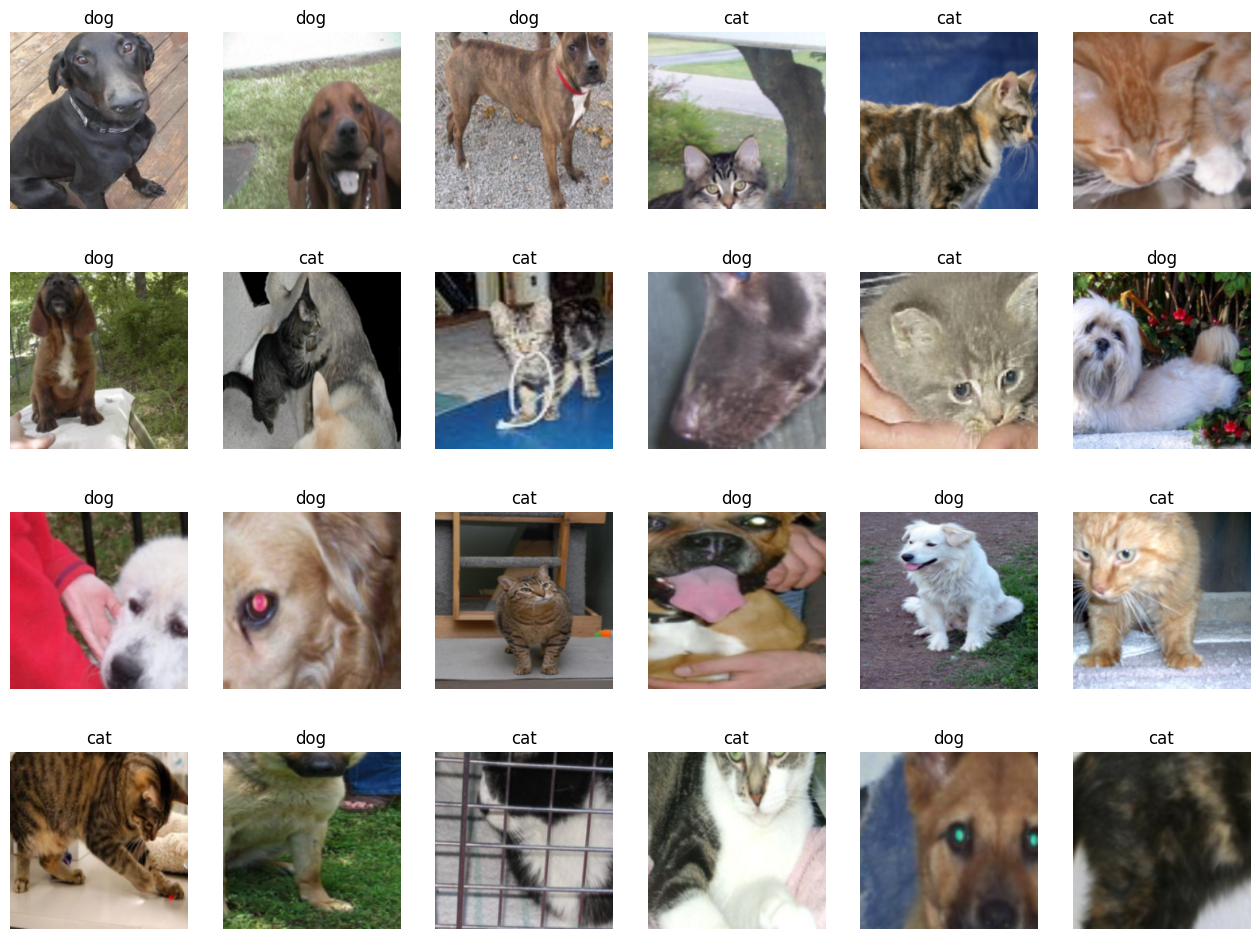

In [11]:
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat',1:'dog'} # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16,24))
for i in range(24): # 24개의 이미지 데이터 출력
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()]) # 레이블 정보(클래스)를 함께 출력
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(),(1,2,0)))
plt.subplots_adjust(bottom=0.2,top=0.6,hspace=0)

iter()는 전달된 데이터의 반복자를 꺼내 반환하며, next()는 그 반복자가 다음에 출력해야 할 요소를 반환한다.

즉, iter()로 반복자를 구하고 그 반복자를 next()에 전달하여 차례대로 꺼낼 수 있다.

np.transpose는 행과 열을 바꿈으로써 행렬의 차원을 바꾸어 준다.

데이터가 준비되었으므로 사전 훈련된 ResNet18 모델을 내려받는다.

In [12]:
resnet18 = models.resnet18(pretrained=True) # pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


ResNet18은 50개의 계층으로 구성된 합성곱 신경망이다. ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망으로 전이 학습에 사용되도록 사전 훈련된 모델을 제공하고 있다.

다음은 내려받은 ResNet18의 합성곱층을 사용하되 파라미터에 대해서는 학습을 하지 않도록 고정시킨다.

In [13]:
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad(resnet18)

모델의 일부를 고정하고 나머지를 학습하고자 할 때 requires_grad=False로 설정한다.

이때 모델의 일부는 합성곱층과 풀링층을 의미한다.

내려받은 ResNet18의 마지막 부분에 완전연결층을 추가한다.

추가된 완전연결층은 개와 고양이 클래스를 분류하는 용도로 사용된다.

In [14]:
resnet18.fc = nn.Linear(512,2) # 2는 클래스가 두 개라는 의미

참고용으로 모델의 파라미터 값들을 확인해 본다.

In [15]:
for name, param in resnet18.named_parameters(): # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
  if param.requires_grad:
    print(name,param.data)

fc.weight tensor([[-0.0008, -0.0244, -0.0442,  ...,  0.0226, -0.0298,  0.0267],
        [ 0.0135, -0.0319, -0.0093,  ...,  0.0442, -0.0026, -0.0357]])
fc.bias tensor([-0.0060,  0.0039])


다음 결과와 같이 파라미터는 weight와 bias가 사용되고 있다.

이제 모델 학습 준비를 위해 모델의 객체를 생성하고 손실 함수를 정의한다.

In [16]:
model = models.resnet18(pretrained=True) # 모델의 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
  param.requires_grad = False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters(): # 완전연결층은 학습
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

모델 학습을 위한 함수를 생성한다.

In [17]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
  since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
  acc_history= []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs): # 에포크(13)만큼 반복
    print('Epoch {}/{}'.format(epoch,num_epochs-1))
    print('-'*10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders: # 데이터로더에 전달된 데이터만큼 반복
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad() # 기울기를 0으로 설정
      outputs = model(inputs) # 순전파 학습
      loss = criterion(outputs,labels)
      _, preds = torch.max(outputs,1)
      loss.backward() # 역전파 학습
      optimizer.step()

      running_loss += loss.item()*inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
      running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

    epoch_loss = running_loss/len(dataloaders.dataset) # 평균 오차 계산
    epoch_acc = running_corrects.double()/len(dataloaders.dataset) # 평균 정확도 계산

    print('Loss:{:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(),os.path.join('','{0:0=2d}.pth'.format(epoch))) # 모델 재사용을 위해 저장해 둡니다.
    print()

  time_elapsed = time.time()-since # 실행 시간(학습 시간)을 계산
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
  print('Best acc: {:4f}'.format(best_acc))
  return acc_history, loss_history # 모델의 정확도와 오차를 반환

학습을 통해 얻어지는 파라미터를 옵티마이저에 전달해서 최종적으로 모델 학습에 사용한다.

In [18]:
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param) # 파라미터 학습 결과를 저장
    print('\t',name)

optimizer = optim.Adam(params_to_update) # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


모델을 학습시킨다.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss:0.6024 Acc: 0.6571

Epoch 1/12
----------
Loss:0.4274 Acc: 0.7948

Epoch 2/12
----------
Loss:0.3424 Acc: 0.8545

Epoch 3/12
----------
Loss:0.2732 Acc: 0.8883

Epoch 4/12
----------
Loss:0.2491 Acc: 0.8961

Epoch 5/12
----------
Loss:0.2691 Acc: 0.8753

Epoch 6/12
----------
Loss:0.2545 Acc: 0.8987

Epoch 7/12
----------
Loss:0.2228 Acc: 0.8987

Epoch 8/12
----------
Loss:0.2329 Acc: 0.8935

Epoch 9/12
----------
Loss:0.2364 Acc: 0.8961

Epoch 10/12
----------
Loss:0.1780 Acc: 0.9429

Epoch 11/12
----------
Loss:0.2401 Acc: 0.8831

Epoch 12/12
----------
Loss:0.2377 Acc: 0.8727

Training complete in 8m 35s
Best acc: 0.942857


약 93%로 상당히 높은 정확도를 보여 준다.

훈련 데이터로는 학습이 잘 되었다고 할 수 있다.

이제 테스트 용도의 데이터를 이용하여 모델 정확도를 측정해 보아야 한다.

테스트 데이터를 불러와 전처리를 한다.

In [24]:
test_path = '/content/080289/080289/chap05/data/catanddog/test'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [25]:
def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob(''+'*.pth')
  saved_models.sort() # 불러온 .pth 파일들을 정렬
  print('saved_model',saved_models)

  for model_path in saved_models:
    print('Loading model',model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs,labels in dataloaders: # 테스트 반복
       inputs = inputs.to(device)
       labels = labels.to(device)

       with torch.no_grad(): # autograd를 사용하지 않겠다는 의미
        outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장

       _,preds = torch.max(outputs.data,1)
       preds[preds>=0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
       preds[preds<0.5]=0 # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
       running_corrects += preds.eq(labels.cpu()).int().sum()

    epoch_acc = running_corrects.double()/len(dataloaders.dataset) # 테스트 데이터의 정확도 계산
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      acc_history.append(epoch_acc.item())
      print()

  time_elapsed = time.time()-since
  print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
  print('Best acc: {:4f}'.format(best_acc))

  return acc_history # 계산된 정확도 반환

In [26]:
val_acc_hist = eval_model(resnet18,test_loader,device)

saved_model []
Validation complete in 0m 0s
Best acc: 0.000000


모델의 학습 결과를 시각적으로 살펴본다.

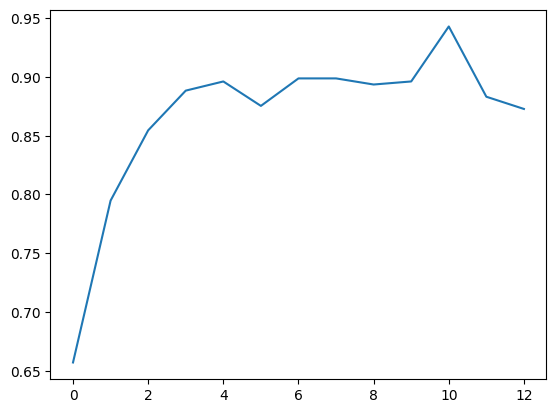

In [27]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

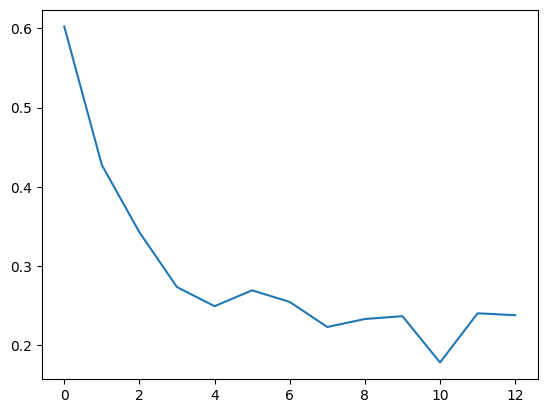

In [28]:
plt.plot(train_loss_hist)
plt.show()

단순히 정확도와 오차 정보를 확인하는 것에 머무르지 않고, 실제로 데이터를 잘 예측하는지 살펴본다.

먼저 예측된 이미지를 출력하기 위한 전처리 함수를 생성한다.

In [29]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image*(np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
  image = image.clip(0,1)
  return image

테스트 데이터셋을 이용하여 실제로도 개와 고양이를 잘 분류하는지 살펴본다.

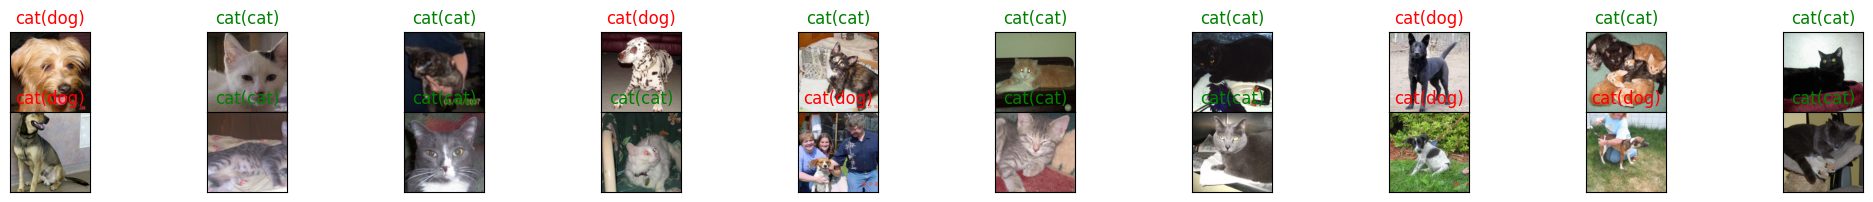

In [32]:
classes = {0:'cat',1:'dog'} # 개와 고양이에 대한 레이블

dataiter = iter(test_loader) # 테스트 데이터셋을 가져옵니다.
images, labels = next(dataiter) # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옵니다.
output = model(images)
_, preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx])) # 이미지 출력을 위해 코드 5-28엣 ㅓ정의한 im_convert 함수를 적용
  ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=('green' if preds[idx]==labels[idx] else 'red'))
plt.subplots_adjust(bottom=0.2,top=0.6,hspace=0)
plt.show()

#### **5.3.2 미세 조정 기법**

미세 조정(fine-tuning) 기법은 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식이다.

특성 추출은 목표 특성을 잘 추출했다는 전제하에 좋은 성능을 낼 수 있다.

특성이 잘못 추출되었다면 미세 조정 기법으로 새로운 이미지 데이터를 사용하여 네트워크의 가중치를 업데이트해서 특성을 다시 추출할 수 있다.

즉, 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것이다.